# **Palavras e temas dominantes**

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Consultando GitHub: https://api.github.com/repos/NadsonCruzSilva/engenheiros_hawaii/contents/ ...
Encontrados 16 arquivos CSV. Baixando...
Lendo: letras_Engenheiros_do_Hawaii_10.000_Destinos__ao_Vivo.csv
Lendo: letras_Engenheiros_do_Hawaii_A_Revolta_dos_Dândis.csv
Lendo: letras_Engenheiros_do_Hawaii_Acústico_MTV_-_Engenheiros_do_Hawaii.csv
Lendo: letras_Engenheiros_do_Hawaii_Alívio_Imediato.csv
Lendo: letras_Engenheiros_do_Hawaii_Dançando_no_Campo_Minado.csv
Lendo: letras_Engenheiros_do_Hawaii_Filmes_de_Guerra,_Canções_de_Amor.csv
Lendo: letras_Engenheiros_do_Hawaii_Gessinger,_Licks_&_Maltz.csv
Lendo: letras_Engenheiros_do_Hawaii_Longe_Demais_das_Capitais.csv
Lendo: letras_Engenheiros_do_Hawaii_Minuano.csv
Lendo: letras_Engenheiros_do_Hawaii_Novos_Horizontes.csv
Lendo: letras_Engenheiros_do_Hawaii_O_Papa_é_Pop.csv
Lendo: letras_Engenheiros_do_Hawaii_Ouça_o_que_eu_digo__não_ouça_ninguém.csv
Lendo: letras_Engenheiros_do_Hawaii_Simples_de_Coração.csv
Lendo: letras_Engenheiros_do_Hawaii_Su

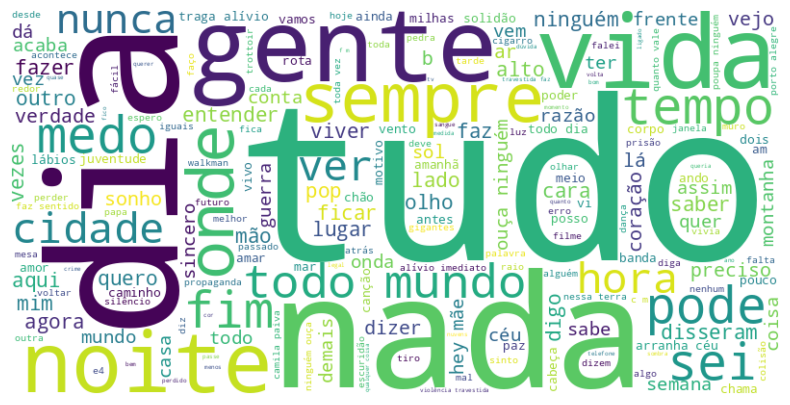

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
from nltk.corpus import stopwords
import re
import requests
import io  # Necessário para ler CSV via StringIO

# Configuração de NLP
nltk.download('stopwords')
pt_stopwords = stopwords.words('portuguese')
pt_stopwords.extend(['pra', 'tá', 'tô', 'né', 'aí', 'então', 'vai', 'vou'])

# ==========================================
# SEUS DADOS
# ==========================================
USUARIO = 'NadsonCruzSilva'
REPOSITORIO = 'engenheiros_hawaii'
PASTA = ''   # deixe '' se os CSV estão na raiz
# ==========================================

def carregar_dados_github(usuario, repositorio, pasta=''):
    api_url = f"https://api.github.com/repos/{usuario}/{repositorio}/contents/{pasta}"

    print(f"Consultando GitHub: {api_url} ...")
    response = requests.get(api_url)

    if response.status_code != 200:
        print(f"Erro ao acessar repositório. Código: {response.status_code}")
        print("Verifique usuário, repositório e se é público.")
        return None

    arquivos = response.json()
    lista_dfs = []

    # Filtra arquivos CSV
    arquivos_csv = [f for f in arquivos if f['name'].endswith('.csv')]

    if not arquivos_csv:
        print("Nenhum arquivo CSV encontrado.")
        return None

    print(f"Encontrados {len(arquivos_csv)} arquivos CSV. Baixando...")

    for arquivo in arquivos_csv:
        try:
            print(f"Lendo: {arquivo['name']}")
            url_raw = arquivo['download_url']

            # Baixar conteúdo de forma robusta (mantido do seu código)
            req_conteudo = requests.get(url_raw)
            conteudo_texto = io.StringIO(req_conteudo.text)

            # Ler CSV
            df_temp = pd.read_csv(conteudo_texto)
            lista_dfs.append(df_temp)

        except Exception as e:
            print(f"Erro ao ler {arquivo['name']}: {e}")

    if lista_dfs:
        return pd.concat(lista_dfs, ignore_index=True)

    return None


# === Função limpa texto (do código novo — ajustada) ===
def limpar_texto(texto):
    if not isinstance(texto, str):
        return ""

    texto = texto.lower()
    texto = re.sub(r'[^\w\sáàâãéêíóôõúç]', ' ', texto)  # mantém acentos
    texto = re.sub(r'\s+', ' ', texto).strip()

    return texto


# ====================
# Execução Principal
# ====================

df_total = carregar_dados_github(USUARIO, REPOSITORIO, PASTA)

if df_total is not None and 'Letra' in df_total.columns:
    print(f"\nSucesso! Total de músicas carregadas: {len(df_total)}")

    df_total['letras_limpas'] = df_total['Letra'].apply(limpar_texto)

    # A. Contagem Simples
    count_vec = CountVectorizer(stop_words=pt_stopwords, max_features=10)
    count_matrix = count_vec.fit_transform(df_total['letras_limpas'])
    soma_palavras = count_matrix.sum(axis=0)
    palavras_freq = [(word, soma_palavras[0, idx]) for word, idx in count_vec.vocabulary_.items()]
    palavras_freq = sorted(palavras_freq, key=lambda x: x[1], reverse=True)

    print("\n--- TOP 10 PALAVRAS MAIS FREQUENTES ---")
    for palavra, qtd in palavras_freq:
        print(f"{palavra}: {qtd}")

    # B. TF-IDF
    tfidf_vec = TfidfVectorizer(stop_words=pt_stopwords, max_features=10)
    tfidf_matrix = tfidf_vec.fit_transform(df_total['letras_limpas'])
    soma_tfidf = tfidf_matrix.sum(axis=0)
    termos_tfidf = [(word, soma_tfidf[0, idx]) for word, idx in tfidf_vec.vocabulary_.items()]
    termos_tfidf = sorted(termos_tfidf, key=lambda x: x[1], reverse=True)

    print("\n--- TOP 10 TERMOS MAIS RELEVANTES (TF-IDF) ---")
    for palavra, score in termos_tfidf:
        print(f"{palavra}: {score:.2f}")

    # C. Nuvem de Palavras
    print("\n--- Gerando Nuvem de Palavras ---")
    texto_completo = " ".join(df_total['letras_limpas'])

    # --- A MUDANÇA ESTÁ AQUI ---
    # Ao colocar set(pt_stopwords), transformamos a lista num conjunto
    # Isso torna a geração da nuvem muito mais rápida
    wordcloud = WordCloud(stopwords=set(pt_stopwords),
                          width=800, height=400,
                          background_color='white').generate(texto_completo)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

else:
    print("\nErro: Não foi possível processar os dados.")
    if df_total is not None:
        print("Colunas disponíveis:", df_total.columns)


# **Classificação intuitiva**

Classificando as letras... aguarde.

--- Resultado da Classificação ---
Sentimento
Melancólica            62
Filosófica             58
Otimista               45
Indefinido / Neutro    12
Name: count, dtype: int64


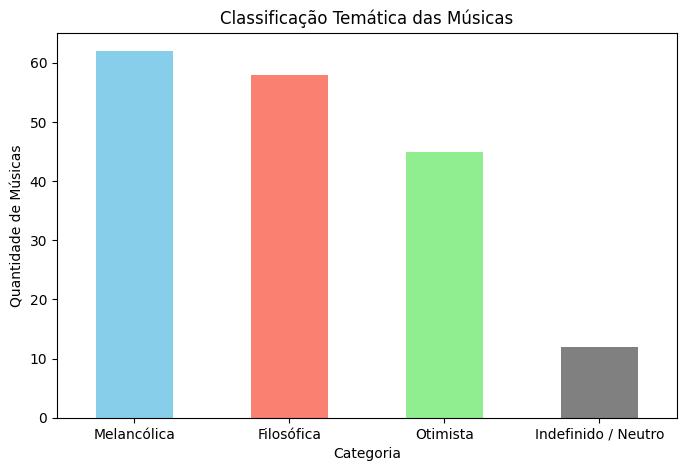


 EXEMPLOS ALEATÓRIOS)

>>> Categoria: Melancólica
   - Piano Bar
   - Vozes
   - Alívio Imediato

>>> Categoria: Otimista
   - Seguir Viagem
   - Longe Demais das Capitais
   - A Conquista do Espaço

>>> Categoria: Filosófica
   - Outras Frequências
   - Segurança
   - Nunca Mais Poder


In [ ]:
# ==========================================
# 1. Definição do "Dicionário de Sentimentos"
# ==========================================

regras_sentimento = {
   'Melancólica': [
    "triste", "tristeza", "tristemente", "tristonho", "depressivo", "chorar", "choro",
    "lágrima", "lágrimas", "angústia", "angustiado", "angustiante", "melancolia",
    "melancólico", "dor", "dorida", "ferida", "feridas", "cicatriz", "cicatrizes",
    "solidão", "solitário", "solitária", "abandono", "abandonado", "abandonei",
    "desamparo", "desesperado", "desespero", "desesperança", "vazio", "escuridão",
    "sombra", "sombrio", "sombria", "noite", "noites", "escuras", "choroso", "mágoa",
    "magoado", "magoada", "tristezas", "sofrer", "sofrimento", "dorido", "doído",
    "nostalgia", "nostálgico", "nostálgica", "lembrança", "lembranças", "saudade",
    "saudades", "partida", "partidas", "adeus", "adeuses", "distante", "distância",
    "perda", "perdido", "perdida", "perdidos", "fim", "final", "terminou", "acabou",
    "ruína", "ruínas", "fracasso", "fracassado", "queda", "quedas", "frio", "frieza",
    "escuro", "escurecer", "cinza", "cinzas", "apagado", "apagada", "apagando",
    "esquecido", "esquecida", "silêncio", "silencioso", "silenciosa", "amargura",
    "amargo", "amarga", "dói", "doeu", "sozinho", "sozinha", "medo", "medos",
    "ansiedade", "tarde", "tardio", "desilusão", "desiludido", "desiludida",
    "desencanto", "cansaço", "exaustão", "exausto", "cansado", "cansada",
    "tristeza profunda", "sombrio", "apagado", "apático", "apatia", "tédio",
    "isolamento", "isolado", "isolada", "negro", "negrume", "rochedo",
    "escurecido", "sombrio", "ruim", "dor emocional", "dor na alma",
    "chaga", "chagas", "agonia", "agoniante", "angustiado", "penumbra",
    "ausência", "ausente", "descontentamento", "abatido", "abatida",
    "tortura", "lamentação", "lamentar", "lamentável", "coração partido",
    "desalento", "pesar", "pesares", "desânimo", "desanimado", "desanimada",
    "desmotivado", "derrota", "derrotado", "culpa", "culpado", "culpada",
    "remorso", "arrependimento", "arrependido", "desprotegido",
    "soturno", "lúgubre", "tenebroso", "perdido no tempo", "apagamento",
    "triste canção", "desesperançado", "cicatriz emocional", "lagrimar",
    "abismo", "esfacelado", "partido", "adormecido", "morrer", "morreu",
    "morrendo", "morto", "funesto", "desalinhado", "falta de cor",
    "moído", "ferido", "machucado"
],
    'Otimista': [
    "alegria", "alegre", "felicidade", "feliz", "sorriso", "sorrir", "riso",
    "esperança", "esperançoso", "esperançar", "brilho", "brilhar", "luz",
    "sol", "ensolarado", "calor", "paz", "paz interior", "harmonia",
    "amor", "carinho", "abraço", "abraços", "cuidar", "alegremente",
    "força", "forte", "coragem", "determinação", "entusiasmo", "entusiasmado",
    "positividade", "positivo", "positiva", "bondade", "gentileza",
    "gratidão", "grato", "grata", "sorte", "prosperidade", "prosperar",
    "vitória", "vitórias", "triunfo", "triunfar", "conquista", "conquistar",
    "felizmente", "beleza", "bonito", "belo", "beleza da vida",
    "energia", "energia boa", "luz própria", "calmo", "calma", "leveza",
    "leve", "leveza da alma", "otimismo", "otimista", "confiança", "confiar",
    "fé", "esperançar", "renascer", "renascimento", "recomeço", "recomeçar",
    "começar", "início", "amanhecer", "manhã", "dia claro", "sorridente",
    "abraço apertado", "vibração", "vibrar", "animado", "animada",
    "celebrar", "celebração", "comemorar", "comemoração", "sonho",
    "sonhar", "realização", "realizar", "sucesso", "crescimento",
    "evolução", "evoluir", "flor", "florescer", "flores", "primavera",
    "colorido", "colorida", "coloridos", "alegrar", "encantar",
    "encanto", "encantado", "encantada", "esperançoso", "otimismo",
    "luz própria", "brilho interior", "otimismo constante",
    "carisma", "carismático", "inspiração", "inspirar", "motivar",
    "motivação", "animar", "reviver", "revitalizar", "vida", "viver",
    "vivo", "positivamente", "plenitude", "pleno", "felicidade plena",
    "radiante", "resplandecer", "resplandecente", "iluminar",
    "iluminado", "iluminada", "abençoado", "abençoada", "benção",
    "confiante", "esperançar", "suave", "suavidade", "amável", "doçura",
    "doce", "abraçar", "acolher", "acolhimento", "união", "amizade",
    "companheirismo", "leveza", "otimismo vibrante", "vitórias pequenas",
    "alegrar-se", "brilho no olhar", "bom humor", "otimismo puro",
    "coração leve", "dias melhores", "melhora", "melhorar"
],
    'Filosófica': [
    "existência", "existir", "existencial", "vida", "morte", "tempo",
    "passado", "presente", "futuro", "memória", "consciência",
    "percepção", "reflexão", "refletir", "pensamento", "pensar",
    "razão", "lógica", "intuição", "sabedoria", "conhecimento",
    "verdade", "busca", "propósito", "sentido", "significado",
    "questionar", "questionamento", "filosofia", "filosófico",
    "essência", "essencial", "destino", "caminho", "jornada",
    "universo", "cosmos", "infinito", "eternidade", "eterno",
    "imanência", "transcendência", "metáfora", "analogia",
    "reflexivo", "ponderar", "ponderação", "dualidade",
    "equilíbrio", "paradoxo", "dilema", "dual", "concepção",
    "ideia", "conceito", "perspectiva", "visão", "observação",
    "observador", "sentir", "sensação", "experiência", "existencialismo",
    "sutil", "complexo", "complexidade", "dimensão", "estrutura",
    "essencialismo", "fenômeno", "aparência", "realidade",
    "subjetivo", "objetivo", "abstrato", "abstração", "contexto",
    "cognição", "consciente", "inconsciente", "profundo",
    "profundidade", "autoconhecimento", "autoconsciência",
    "virtude", "ética", "moral", "sabedoria ancestral",
    "princípio", "origem", "começo", "raiz", "cerne",
    "ser", "ser humano", "natureza", "essência da vida",
    "existência humana", "perguntas", "indagar", "indagação",
    "controverso", "causa", "efeito", "causalidade",
    "ordem", "caos", "aleatoriedade", "probabilidade",
    "realidade", "verdade interior", "caminho interno",
    "viagem interna", "compreensão", "entendimento",
    "interpretação", "ponto de vista", "projeção",
    "mundo interior", "imanente", "transcendente",
    "busca interior", "significado profundo", "alma",
    "espírito", "espiritual", "dimensão maior", "questões profundas",
    "reflexão pessoal", "transcender", "eternizar", "atuar no mundo",
    "plano existencial", "finito", "infinito", "complexidade humana",
    "ideologia", "paradigma", "equação da vida", "tempo interior",
    "subjetividade", "conexão", "intencionalidade"
]
}

# ==========================================
# 2. Função Classificadora
# ==========================================

def classificar_letra(texto):
    if not isinstance(texto, str):
        return "Indefinido"

    # Inicializa o placar
    placar = {'Melancólica': 0, 'Otimista': 0, 'Filosófica': 0}

    # Separa as palavras da letra
    palavras = texto.split()

    # Para cada palavra da letra, verifica se ela está em alguma das listas
    for palavra in palavras:
        for categoria, lista_palavras in regras_sentimento.items():
            if palavra in lista_palavras:
                placar[categoria] += 1

    # Descobre qual categoria teve a maior pontuação
    # Se houver empate ou zero pontos, definimos como 'Indefinido' ou pegamos o maior
    maior_pontuacao = max(placar.values())

    if maior_pontuacao == 0:
        return "Indefinido / Neutro"

    # Retorna a categoria com maior pontuação
    # (Pega a chave do dicionário que tem o valor igual à maior pontuação)
    vencedor = [k for k, v in placar.items() if v == maior_pontuacao][0]
    return vencedor

# ==========================================
# 3. Aplicação e Resultados
# ==========================================

print("Classificando as letras... aguarde.")

# Cria uma nova coluna no DataFrame chamada 'Sentimento'
# Usa a coluna 'letras_limpas' que criamos no passo anterior
df_total['Sentimento'] = df_total['letras_limpas'].apply(classificar_letra)

# Mostra a contagem de músicas por categoria
contagem = df_total['Sentimento'].value_counts()
print("\n--- Resultado da Classificação ---")
print(contagem)

# Visualização Gráfica
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
contagem.plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen', 'gray'])
plt.title('Classificação Temática das Músicas')
plt.xlabel('Categoria')
plt.ylabel('Quantidade de Músicas')
plt.xticks(rotation=0)
plt.show()

# ==========================================
# 4. Ver exemplos ALEATÓRIOS
# ==========================================
print("\n" + "="*40)
print(" EXEMPLOS ALEATÓRIOS)")
print("="*40)

for categoria in regras_sentimento.keys():
    print(f"\n>>> Categoria: {categoria}")

    # 1. Filtra as músicas daquela categoria
    df_filtrado = df_total[df_total['Sentimento'] == categoria]

    # 2. Descobre quantas músicas existem nessa categoria
    qtd_existente = len(df_filtrado)

    if qtd_existente == 0:
        print("   (Nenhuma música encontrada nesta categoria)")
    else:
        # 3. Define quantas vamos mostrar (3, ou menos se não houver 3)
        # O min() evita erro se a categoria tiver só 1 ou 2 músicas
        qtd_amostra = min(3, qtd_existente)

        # 4. Pega a amostra aleatória
        amostra = df_filtrado['Título da Música'].sample(n=qtd_amostra)

        # 5. Imprime
        for musica in amostra:
            print(f"   - {musica}")

# **Similaridade entre letras**

In [ ]:
# 1. Instalação (caso não tenha rodado antes)
!pip install sentence-transformers

import pandas as pd
from sentence_transformers import SentenceTransformer, util
import torch

# Carregamento do modelo (se já carregou antes, ele usa o cache)
print("\nCarregando modelo de Inteligência Artificial...")
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

# 2. Gerar os Embeddings
print("Calculando a 'assinatura matemática' de cada música...")
embeddings = model.encode(df_total['letras_limpas'].tolist(), convert_to_tensor=True)

print("Pronto! Agora podemos comparar as músicas.")

# 3. Função de Recomendação Inteligente (Sem Repetições)
def encontrar_similares(nome_musica, top_n=5):
    # Verifica se a música existe
    busca = df_total[df_total['Título da Música'].str.lower() == nome_musica.lower()]

    if len(busca) == 0:
        print(f"Música '{nome_musica}' não encontrada.")
        return

    # Pega o índice e o título oficial da música escolhida
    idx_musica = busca.index[0]
    titulo_real = df_total.loc[idx_musica, 'Título da Música']

    # Calcula similaridade
    scores_similiaridade = util.cos_sim(embeddings[idx_musica], embeddings)[0]

    # --- A MUDANÇA ESTÁ AQUI ---
    # Buscamos um "pool" maior (ex: 50) para ter margem de descarte de duplicatas
    top_resultados = torch.topk(scores_similiaridade, k=50)

    print(f"\n--- Se você gosta de '{titulo_real}', talvez goste de: ---")

    contador = 0

    for score, idx in zip(top_resultados.values, top_resultados.indices):
        idx = int(idx)
        titulo_candidato = df_total.loc[idx, 'Título da Música']
        album_candidato = df_total.loc[idx, 'Álbum']

        # REGRA 1: Não pode ser a própria linha da música original
        if idx == idx_musica:
            continue

        # REGRA 2: Não pode ter o mesmo título (Ignora maiúsculas/minúsculas)
        # Isso evita "Piano Bar" (CD) recomendar "Piano Bar" (Ao Vivo) se tiverem o mesmo nome
        if titulo_candidato.lower().strip() == titulo_real.lower().strip():
            continue

        # Se passou nos filtros, mostramos
        print(f"- {titulo_candidato} (Álbum: {album_candidato}) [Similaridade: {score:.2f}]")

        contador += 1
        # Se já achamos a quantidade desejada (ex: 5), paramos o loop
        if contador >= top_n:
            break

# ==========================================
# TESTE AQUI
# ==========================================
encontrar_similares("Infinita Highway")
print("\n")
encontrar_similares("O Papa é Pop")


Carregando modelo de Inteligência Artificial...
Calculando a 'assinatura matemática' de cada música...
Pronto! Agora podemos comparar as músicas.

--- Se você gosta de 'Infinita Highway', talvez goste de: ---
- Cruzada (Álbum: Tchau Radar) [Similaridade: 0.63]
- Deserto Freezer (Álbum: Minuano) [Similaridade: 0.61]
- A Promessa (Álbum: 10.000 Destinos: ao Vivo) [Similaridade: 0.52]
- A Promessa (Álbum: Simples de Coração) [Similaridade: 0.52]
- Ando Só (Álbum: Várias Variáveis) [Similaridade: 0.52]



--- Se você gosta de 'O Papa é pop', talvez goste de: ---
- Outono Em Porto Alegre (Álbum: Dançando no Campo Minado) [Similaridade: 0.57]
- A Promessa (Álbum: 10.000 Destinos: ao Vivo) [Similaridade: 0.57]
- A Promessa (Álbum: Simples de Coração) [Similaridade: 0.57]
- A Verdade a Ver Navios (Álbum: Alívio Imediato) [Similaridade: 0.55]
- A Verdade a Ver Navios (Álbum: Ouça o que eu digo: não ouça ninguém) [Similaridade: 0.55]
